In [3]:
from datetime import datetime, date

def parse_datetime(date):
  return datetime.strptime(date.split('-')[0].strip(), "%d.%m.%Y %H:%M")

print(parse_datetime("18.11.2023 06:00 - 18.11.2023"))


2023-11-18 06:00:00


Index(['datetime', 'date', 'hour', 'eur_per_mwh'], dtype='object')
                            datetime         hour  eur_per_mwh
count                           6863  6863.000000  6863.000000
mean   2023-05-23 23:42:21.454174720    11.501384    53.650363
min              2023-01-01 00:00:00     0.000000   -60.040000
25%              2023-03-13 11:30:00     6.000000    15.215000
50%              2023-05-24 00:00:00    12.000000    40.480000
75%              2023-08-03 11:30:00    17.500000    80.900000
max              2023-10-13 23:00:00    23.000000   549.950000
std                              NaN     6.922245    50.410970


<Axes: xlabel='hour'>

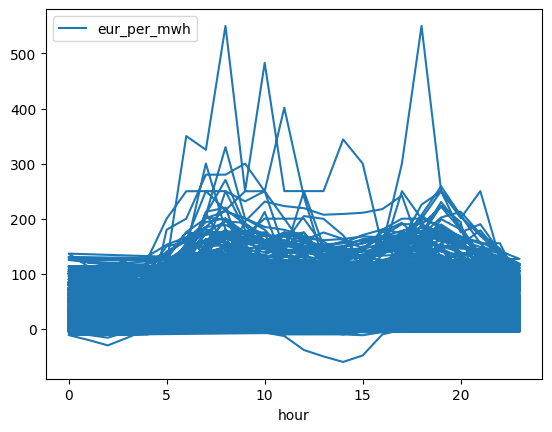

In [26]:
import csv
import matplotlib.pyplot as plt
import pandas as pandas
from dataclasses import dataclass

@dataclass
class DataEntry:
    datetime: datetime
    date: date
    hour: int
    eur_per_mwh: float



def load_data():
    with open('prices.csv') as csvfile:
        reader = csv.reader(csvfile, delimiter=",")
        next(reader) #ignore header
        for row in reader:
            [date, price] = row[0:2]
            try:
              d = parse_datetime(date)
              yield DataEntry(datetime=d, date=d.date(),hour=d.hour, eur_per_mwh=float(price))
            except ValueError:
              pass    

dataset = pandas.DataFrame(data=load_data())
dataset.index = dataset["datetime"]

print(dataset.columns)
print(dataset.describe())

dataset.plot('hour', 'eur_per_mwh')

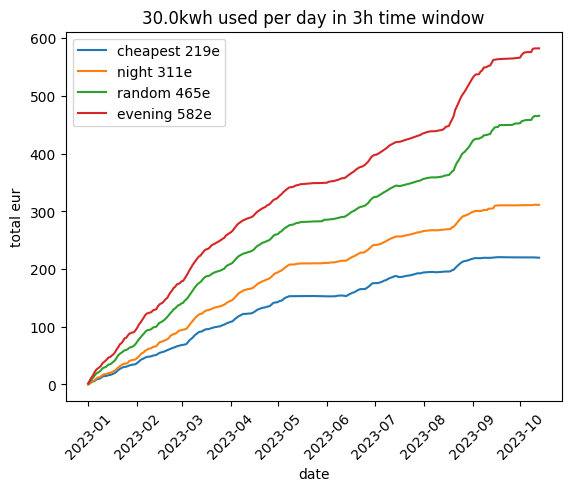

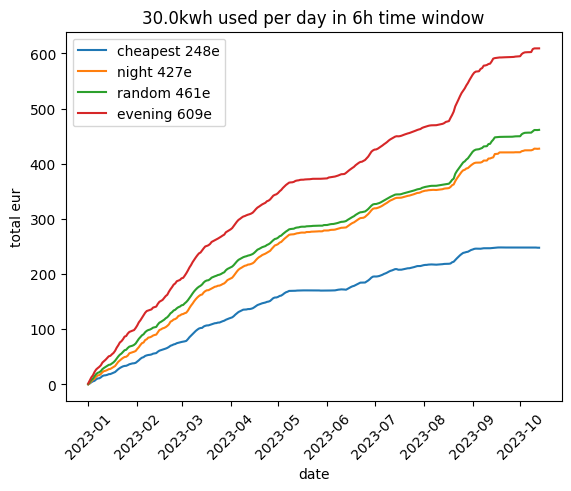

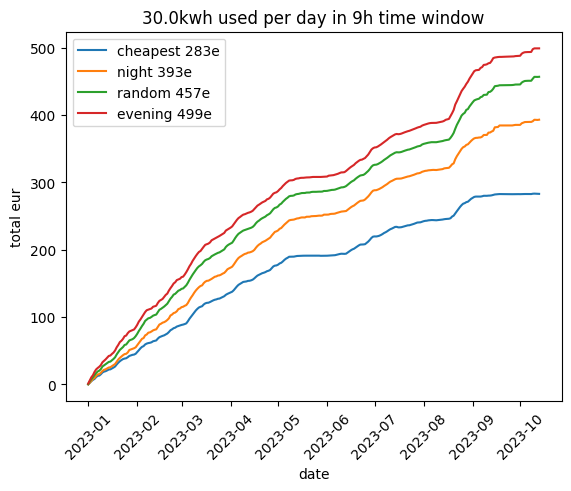

In [120]:

import math

bydate = dataset.groupby("date")

result = pandas.DataFrame(columns=["method"])

def get_total(sampler, power_mw):
    result = pandas.DataFrame(columns=["date", "cost"])
    for idx,[date, values] in enumerate(bydate):
        values.index = values["datetime"]
        sample = sampler(values)
        result.loc[idx] = {"date": date, "cost": sum(sample["eur_per_mwh"] * power_mw)}
    return result





for nhours in [3, 6, 9]:
    mwh_used_per_day = 0.030
    power_mw = mwh_used_per_day/nhours
    cheapest = get_total(lambda x: x.nsmallest(nhours,columns="eur_per_mwh"), power_mw)
    random = get_total(lambda x: x.sample(nhours), power_mw)
    night = get_total(lambda x: x.between_time(f"{4 - math.floor(nhours/2)}:00", f"{4 + math.floor(nhours/2)}:00"), power_mw)
    evening = get_total(lambda x: x.between_time(f"{18 - math.floor(nhours/2)}:00", f"{18 + math.floor(nhours/2)}:00"), power_mw)
    plt.title(f"{mwh_used_per_day * 1000}kwh used per day in {nhours}h time window")
    plt.xlabel("date")
    plt.ylabel("total eur")
    plt.xticks(rotation=45)

    def plot_dataset(dataset, label):
        total = dataset['cost'].sum()
        plt.plot(dataset["date"], dataset["cost"].cumsum(), label=f'{label} {round(total)}e')    

    plot_dataset(cheapest, "cheapest")
    plot_dataset(night, "night")
    plot_dataset(random, "random")
    plot_dataset(evening, "evening")
    plt.legend()
    plt.show()





